In [1]:
from deepset import *
MODEL = DeepSet(in_features=5, feats=[80,120,70,50,8], n_class=2,pool="mean") #for full dataset Mean pooling, for small dataset Max pooling
model=MODEL
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=model.to(device) 


pool:  mean
pool:  mean
pool:  mean
pool:  mean
pool:  mean
pool:  mean


In [2]:
import torch
from torch.utils.data import Dataset
import pickle
import os
import numpy as np
import random
import pandas as pd

class StreamingHcaDataset(Dataset): 
    def __init__(self, proton_dir, pion_dir, features=["x", "y", "z", "total_energy","mean_time"]):
        super().__init__()
        
        self.proton_files = sorted([os.path.join(proton_dir, f) for f in os.listdir(proton_dir) if f.endswith(".pkl")])
        self.pion_files = sorted([os.path.join(pion_dir, f) for f in os.listdir(pion_dir) if f.endswith(".pkl")])

        self.features = features
        self.all_files = self.proton_files + self.pion_files  # Combine file lists
        self.labels = [0] * len(self.proton_files) + [1] * len(self.pion_files)  # 0 for proton, 1 for pion

    def __len__(self):
        return len(self.all_files)  # Total number of files

    def _load_file(self, file_path, label):
        """Loads a single pickle file (containing a single DataFrame) and returns point cloud data with labels."""
        # with open(file_path, "rb") as f:
        #     df = pickle.load(f)  # Load single DataFrame
    
        df=pd.read_pickle(file_path)
        # df=pd.read_parquet(file_path,engine='fastparquet')
        df=df[df["total_energy"]>5]
        
          
        part_feat = df[self.features].to_numpy()

        # Handle NaN and Inf values
        part_feat[np.isnan(part_feat)] = 0.0
        part_feat[np.isinf(part_feat)] = 0.0

        return {
            "part": torch.tensor(part_feat, dtype=torch.float32),
            "label": torch.tensor(label, dtype=torch.long),
            "seq_length": torch.tensor(part_feat.shape[0], dtype=torch.long),
        }

    def __getitem__(self, idx):
        random_idx = random.randint(0, len(self.all_files) - 1)  # Pick a random file
        file_path = self.all_files[random_idx]
        label = self.labels[random_idx]

        return self._load_file(file_path, label)  # Return data from the chosen file


In [3]:
import torch
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    """Custom collate function to handle variable-length point cloud data."""
    parts = [item["part"] for item in batch]  # List of tensors (each of shape [N, 5])
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)  # Convert list to tensor
    seq_lengths = torch.tensor([item["seq_length"] for item in batch], dtype=torch.long)  # Convert list to tensor

    # Pad variable-length tensors to the longest sequence in the batch
    padded_parts = pad_sequence(parts, batch_first=True, padding_value=0.0)  # Shape [batch_size, max_seq_len, 5]

    return {"part": padded_parts, "label": labels, "seq_length": seq_lengths}


In [4]:

energy="10"
granularity="200"
pion_dir =f"/mnt/c/Users/hnayak/Documents/{energy}GeV/small_PKL_pion_{energy}GeV_{granularity}"
proton_dir =f"/mnt/c/Users/hnayak/Documents/{energy}GeV/small_PKL_proton_{energy}GeV_{granularity}"
name=proton_dir.replace(f"/mnt/c/Users/hnayak/Documents/{energy}GeV/small_PKL_proton_","")
print(name)
from torch.utils.data import random_split, DataLoader

# Define dataset
train_dataset = StreamingHcaDataset(proton_dir=proton_dir, pion_dir=pion_dir)

# Define split sizes
total_size = len(train_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # Ensure the sum matches total_size

# Split dataset
train_set, val_set, test_set = random_split(train_dataset, [train_size, val_size, test_size])

# Define DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=32)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, collate_fn=collate_fn,num_workers=32)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=collate_fn,num_workers=32)


print(f"Train: {train_size}, Validation: {val_size}, Test: {test_size}")



10GeV_200
Train: 160000, Validation: 20000, Test: 20000


In [5]:
import tqdm
def test_model(model, test_loader, criterion=None, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()  # Set model to evaluation mode

    total_loss = 0.0
    correct = 0
    total_samples = 0

    # Progress bar for testing
    test_loader_tqdm = tqdm(enumerate(test_loader), total=len(test_loader), desc="Testing")

    with torch.no_grad():
        for i,batch in test_loader_tqdm:
            parts = batch["part"].to(device)         # Input point cloud data
            labels = batch["label"].to(device)  # Labels
            batch_size,seq_len,feat_dim=parts.shape
            parts=parts.cpu().numpy().reshape(-1,feat_dim)
            qt = QuantileTransformer(output_distribution='normal', random_state=42)
            parts = qt.fit_transform(parts)
            parts=torch.tensor(parts).reshape(batch_size,seq_len,feat_dim).to(device)

            outputs = model(parts)  # Forward pass
            loss = criterion(outputs, labels) if criterion else 0  # Compute loss if provided
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get class prediction
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            test_loader_tqdm.set_postfix(loss=loss.item())  # Update progress bar

    avg_loss = total_loss / len(test_loader) if criterion else 0
    accuracy = correct / total_samples * 100

    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss , accuracy

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import QuantileTransformer

def train_model(model, train_loader, val_loader, num_epochs=2, learning_rate=5e-4, device=None, save_path=f"./Models/Z_{name}.pth", log_path=f"./Logs/log_summary_Z_{name}.csv"):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float("inf")  # Initialize best loss

    log_data = []  # To store log info for CSV

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, batch in train_loader_tqdm:
            parts = batch["part"].to(device)
            batch_size, seq_len, feat_dim = parts.shape
            parts = parts.cpu().numpy().reshape(-1, feat_dim)
            qt = QuantileTransformer(output_distribution='normal', random_state=42)
            parts = qt.fit_transform(parts)
            parts = torch.tensor(parts).reshape(batch_size, seq_len, feat_dim).float().to(device)

            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(parts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_loader_tqdm.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)
        val_loss, Accuracy = test_model(model, val_loader, criterion, device)
         

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save log
        log_data.append({
            "Epoch": epoch + 1,
            "Train Loss": avg_train_loss,
            "Val Loss": val_loss,
            "Accuracy": Accuracy,  # Placeholder for accuracy
        })

        # Save model if validation improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at epoch {epoch+1} with val loss {val_loss:.4f}")

    # Save the log to CSV
    df_log = pd.DataFrame(log_data)
    df_log.to_csv(log_path, index=False)
    print(f"Training log saved to {log_path}")
    print("Training complete!")


In [7]:

if __name__ == "__main__":
    #Train the model
    train_model(model, train_loader,val_loader=val_loader, num_epochs=60, learning_rate=5e-4, device=device)

Testing: 100%|██████████| 625/625 [00:12<00:00, 48.65it/s, loss=0.303]


Test Loss: 0.3609, Accuracy: 83.64%
Epoch [1/60], Train Loss: 0.4587, Val Loss: 0.3609
Model saved at epoch 1 with val loss 0.3609


Testing: 100%|██████████| 625/625 [00:13<00:00, 47.73it/s, loss=0.264] 


Test Loss: 0.2854, Accuracy: 88.05%
Epoch [2/60], Train Loss: 0.3089, Val Loss: 0.2854
Model saved at epoch 2 with val loss 0.2854


Testing: 100%|██████████| 625/625 [00:13<00:00, 47.71it/s, loss=0.281] 


Test Loss: 0.2597, Accuracy: 88.86%
Epoch [3/60], Train Loss: 0.2766, Val Loss: 0.2597
Model saved at epoch 3 with val loss 0.2597


Testing: 100%|██████████| 625/625 [00:13<00:00, 46.48it/s, loss=0.231] 

Test Loss: 0.2867, Accuracy: 87.50%
Epoch [4/60], Train Loss: 0.2602, Val Loss: 0.2867



Testing: 100%|██████████| 625/625 [00:13<00:00, 46.82it/s, loss=0.243] 


Test Loss: 0.2315, Accuracy: 90.12%
Epoch [5/60], Train Loss: 0.2491, Val Loss: 0.2315
Model saved at epoch 5 with val loss 0.2315


Testing: 100%|██████████| 625/625 [00:13<00:00, 47.18it/s, loss=0.199] 

Test Loss: 0.2670, Accuracy: 88.63%
Epoch [6/60], Train Loss: 0.2428, Val Loss: 0.2670



Testing: 100%|██████████| 625/625 [00:13<00:00, 46.80it/s, loss=0.368] 


Test Loss: 0.2214, Accuracy: 90.62%
Epoch [7/60], Train Loss: 0.2365, Val Loss: 0.2214
Model saved at epoch 7 with val loss 0.2214


Testing: 100%|██████████| 625/625 [00:12<00:00, 50.02it/s, loss=0.216] 


Test Loss: 0.2191, Accuracy: 90.51%
Epoch [8/60], Train Loss: 0.2320, Val Loss: 0.2191
Model saved at epoch 8 with val loss 0.2191


Testing: 100%|██████████| 625/625 [00:13<00:00, 45.99it/s, loss=0.183] 


Test Loss: 0.2163, Accuracy: 90.83%
Epoch [9/60], Train Loss: 0.2272, Val Loss: 0.2163
Model saved at epoch 9 with val loss 0.2163


Testing: 100%|██████████| 625/625 [00:13<00:00, 46.72it/s, loss=0.134] 


Test Loss: 0.2102, Accuracy: 91.18%
Epoch [10/60], Train Loss: 0.2207, Val Loss: 0.2102
Model saved at epoch 10 with val loss 0.2102


Testing: 100%|██████████| 625/625 [00:15<00:00, 41.50it/s, loss=0.131] 

Test Loss: 0.2109, Accuracy: 90.88%
Epoch [11/60], Train Loss: 0.2148, Val Loss: 0.2109



Testing: 100%|██████████| 625/625 [00:15<00:00, 40.85it/s, loss=0.104] 


Test Loss: 0.2080, Accuracy: 91.26%
Epoch [12/60], Train Loss: 0.2117, Val Loss: 0.2080
Model saved at epoch 12 with val loss 0.2080


Testing: 100%|██████████| 625/625 [00:15<00:00, 41.61it/s, loss=0.102] 


Test Loss: 0.2043, Accuracy: 91.47%
Epoch [13/60], Train Loss: 0.2121, Val Loss: 0.2043
Model saved at epoch 13 with val loss 0.2043


Testing: 100%|██████████| 625/625 [00:13<00:00, 46.20it/s, loss=0.133] 

Test Loss: 0.2314, Accuracy: 89.88%
Epoch [14/60], Train Loss: 0.2090, Val Loss: 0.2314



Testing: 100%|██████████| 625/625 [00:15<00:00, 41.42it/s, loss=0.131] 


Test Loss: 0.1986, Accuracy: 91.72%
Epoch [15/60], Train Loss: 0.2040, Val Loss: 0.1986
Model saved at epoch 15 with val loss 0.1986


Testing: 100%|██████████| 625/625 [00:15<00:00, 41.51it/s, loss=0.177] 


Test Loss: 0.1974, Accuracy: 91.64%
Epoch [16/60], Train Loss: 0.2010, Val Loss: 0.1974
Model saved at epoch 16 with val loss 0.1974


Testing: 100%|██████████| 625/625 [00:15<00:00, 41.46it/s, loss=0.177] 


Test Loss: 0.1867, Accuracy: 92.14%
Epoch [17/60], Train Loss: 0.2011, Val Loss: 0.1867
Model saved at epoch 17 with val loss 0.1867


Testing: 100%|██████████| 625/625 [00:15<00:00, 41.30it/s, loss=0.212] 

Test Loss: 0.2010, Accuracy: 91.34%
Epoch [18/60], Train Loss: 0.1985, Val Loss: 0.2010



Testing: 100%|██████████| 625/625 [00:15<00:00, 41.40it/s, loss=0.371] 

Test Loss: 0.2181, Accuracy: 90.72%
Epoch [19/60], Train Loss: 0.1962, Val Loss: 0.2181



Testing: 100%|██████████| 625/625 [00:14<00:00, 42.65it/s, loss=0.112] 

Test Loss: 0.1941, Accuracy: 92.14%
Epoch [20/60], Train Loss: 0.1918, Val Loss: 0.1941



Testing: 100%|██████████| 625/625 [00:15<00:00, 41.06it/s, loss=0.111] 

Test Loss: 0.1890, Accuracy: 92.15%
Epoch [21/60], Train Loss: 0.1913, Val Loss: 0.1890



Testing: 100%|██████████| 625/625 [00:15<00:00, 40.91it/s, loss=0.215] 

Test Loss: 0.1913, Accuracy: 91.89%
Epoch [22/60], Train Loss: 0.1907, Val Loss: 0.1913



Testing: 100%|██████████| 625/625 [00:15<00:00, 41.21it/s, loss=0.187] 

Test Loss: 0.2467, Accuracy: 89.73%
Epoch [23/60], Train Loss: 0.1877, Val Loss: 0.2467



Testing: 100%|██████████| 625/625 [00:15<00:00, 40.99it/s, loss=0.203] 

Test Loss: 0.1942, Accuracy: 91.88%
Epoch [24/60], Train Loss: 0.1893, Val Loss: 0.1942



Testing: 100%|██████████| 625/625 [00:13<00:00, 45.84it/s, loss=0.106] 


Test Loss: 0.1720, Accuracy: 92.63%
Epoch [25/60], Train Loss: 0.1893, Val Loss: 0.1720
Model saved at epoch 25 with val loss 0.1720


Testing: 100%|██████████| 625/625 [00:15<00:00, 40.61it/s, loss=0.146] 

Test Loss: 0.1745, Accuracy: 92.81%
Epoch [26/60], Train Loss: 0.1863, Val Loss: 0.1745



Testing: 100%|██████████| 625/625 [00:14<00:00, 42.38it/s, loss=0.237] 


Test Loss: 0.1737, Accuracy: 92.58%
Epoch [27/60], Train Loss: 0.1865, Val Loss: 0.1737


Testing: 100%|██████████| 625/625 [00:14<00:00, 42.45it/s, loss=0.213] 


Test Loss: 0.1725, Accuracy: 92.63%
Epoch [28/60], Train Loss: 0.1841, Val Loss: 0.1725


Testing: 100%|██████████| 625/625 [00:14<00:00, 42.40it/s, loss=0.341] 

Test Loss: 0.1796, Accuracy: 92.22%
Epoch [29/60], Train Loss: 0.1828, Val Loss: 0.1796



Testing: 100%|██████████| 625/625 [00:14<00:00, 42.92it/s, loss=0.193] 


Test Loss: 0.1699, Accuracy: 92.95%
Epoch [30/60], Train Loss: 0.1805, Val Loss: 0.1699
Model saved at epoch 30 with val loss 0.1699


Testing: 100%|██████████| 625/625 [00:14<00:00, 43.14it/s, loss=0.265] 

Test Loss: 0.1968, Accuracy: 91.77%
Epoch [31/60], Train Loss: 0.1797, Val Loss: 0.1968



Testing: 100%|██████████| 625/625 [00:14<00:00, 42.48it/s, loss=0.289] 


Test Loss: 0.1992, Accuracy: 91.33%
Epoch [32/60], Train Loss: 0.1786, Val Loss: 0.1992


Testing: 100%|██████████| 625/625 [00:14<00:00, 42.37it/s, loss=0.163] 


Test Loss: 0.1680, Accuracy: 92.96%
Epoch [33/60], Train Loss: 0.1761, Val Loss: 0.1680
Model saved at epoch 33 with val loss 0.1680


Testing: 100%|██████████| 625/625 [00:14<00:00, 42.57it/s, loss=0.0787]


Test Loss: 0.1750, Accuracy: 92.60%
Epoch [34/60], Train Loss: 0.1769, Val Loss: 0.1750


Testing: 100%|██████████| 625/625 [00:14<00:00, 42.59it/s, loss=0.171] 

Test Loss: 0.1687, Accuracy: 92.80%
Epoch [35/60], Train Loss: 0.1759, Val Loss: 0.1687



Testing: 100%|██████████| 625/625 [00:14<00:00, 42.49it/s, loss=0.149] 

Test Loss: 0.2587, Accuracy: 89.63%
Epoch [36/60], Train Loss: 0.1775, Val Loss: 0.2587



Testing: 100%|██████████| 625/625 [00:14<00:00, 42.21it/s, loss=0.167] 


Test Loss: 0.1634, Accuracy: 93.26%
Epoch [37/60], Train Loss: 0.1790, Val Loss: 0.1634
Model saved at epoch 37 with val loss 0.1634


Testing: 100%|██████████| 625/625 [00:14<00:00, 42.11it/s, loss=0.211] 

Test Loss: 0.1717, Accuracy: 92.65%
Epoch [38/60], Train Loss: 0.1750, Val Loss: 0.1717



Testing: 100%|██████████| 625/625 [00:13<00:00, 46.04it/s, loss=0.0526]


Test Loss: 0.1912, Accuracy: 91.83%
Epoch [39/60], Train Loss: 0.1742, Val Loss: 0.1912


Testing: 100%|██████████| 625/625 [00:14<00:00, 42.08it/s, loss=0.163] 

Test Loss: 0.1839, Accuracy: 91.98%
Epoch [40/60], Train Loss: 0.1730, Val Loss: 0.1839



Testing: 100%|██████████| 625/625 [00:14<00:00, 42.51it/s, loss=0.0954] 

Test Loss: 0.1650, Accuracy: 93.16%
Epoch [41/60], Train Loss: 0.1733, Val Loss: 0.1650



Testing: 100%|██████████| 625/625 [00:14<00:00, 42.41it/s, loss=0.165] 


Test Loss: 0.1693, Accuracy: 92.96%
Epoch [42/60], Train Loss: 0.1718, Val Loss: 0.1693


Testing: 100%|██████████| 625/625 [00:14<00:00, 41.73it/s, loss=0.0744]

Test Loss: 0.1648, Accuracy: 93.23%
Epoch [43/60], Train Loss: 0.1725, Val Loss: 0.1648



Testing: 100%|██████████| 625/625 [00:14<00:00, 42.31it/s, loss=0.185] 

Test Loss: 0.1674, Accuracy: 92.81%
Epoch [44/60], Train Loss: 0.1711, Val Loss: 0.1674



Testing: 100%|██████████| 625/625 [00:14<00:00, 43.18it/s, loss=0.167] 


Test Loss: 0.1593, Accuracy: 93.47%
Epoch [45/60], Train Loss: 0.1709, Val Loss: 0.1593
Model saved at epoch 45 with val loss 0.1593


Testing: 100%|██████████| 625/625 [00:14<00:00, 42.38it/s, loss=0.145] 


Test Loss: 0.1720, Accuracy: 92.58%
Epoch [46/60], Train Loss: 0.1699, Val Loss: 0.1720


Testing: 100%|██████████| 625/625 [00:14<00:00, 42.26it/s, loss=0.24]  

Test Loss: 0.1634, Accuracy: 93.14%
Epoch [47/60], Train Loss: 0.1689, Val Loss: 0.1634



Testing: 100%|██████████| 625/625 [00:14<00:00, 42.26it/s, loss=0.229] 

Test Loss: 0.1952, Accuracy: 91.51%
Epoch [48/60], Train Loss: 0.1704, Val Loss: 0.1952



Testing: 100%|██████████| 625/625 [00:14<00:00, 42.55it/s, loss=0.289] 


Test Loss: 0.1730, Accuracy: 92.70%
Epoch [49/60], Train Loss: 0.1700, Val Loss: 0.1730


Testing: 100%|██████████| 625/625 [00:13<00:00, 45.65it/s, loss=0.567] 

Test Loss: 0.1795, Accuracy: 92.45%
Epoch [50/60], Train Loss: 0.1676, Val Loss: 0.1795



Testing: 100%|██████████| 625/625 [00:14<00:00, 42.68it/s, loss=0.291] 


Test Loss: 0.1590, Accuracy: 93.29%
Epoch [51/60], Train Loss: 0.1658, Val Loss: 0.1590
Model saved at epoch 51 with val loss 0.1590


Testing: 100%|██████████| 625/625 [00:14<00:00, 42.41it/s, loss=0.242] 


Test Loss: 0.1903, Accuracy: 91.85%
Epoch [52/60], Train Loss: 0.1673, Val Loss: 0.1903


Testing: 100%|██████████| 625/625 [00:13<00:00, 44.66it/s, loss=0.221] 

Test Loss: 0.1744, Accuracy: 92.73%
Epoch [53/60], Train Loss: 0.1656, Val Loss: 0.1744



Testing: 100%|██████████| 625/625 [00:14<00:00, 42.28it/s, loss=0.2]   

Test Loss: 0.1632, Accuracy: 93.31%
Epoch [54/60], Train Loss: 0.1663, Val Loss: 0.1632



Testing: 100%|██████████| 625/625 [00:14<00:00, 42.57it/s, loss=0.217] 

Test Loss: 0.1939, Accuracy: 91.65%
Epoch [55/60], Train Loss: 0.1667, Val Loss: 0.1939



Testing: 100%|██████████| 625/625 [00:14<00:00, 42.00it/s, loss=0.144] 


Test Loss: 0.1538, Accuracy: 93.46%
Epoch [56/60], Train Loss: 0.1642, Val Loss: 0.1538
Model saved at epoch 56 with val loss 0.1538


Testing: 100%|██████████| 625/625 [00:14<00:00, 42.34it/s, loss=0.196] 


Test Loss: 0.1534, Accuracy: 93.66%
Epoch [57/60], Train Loss: 0.1653, Val Loss: 0.1534
Model saved at epoch 57 with val loss 0.1534


Testing: 100%|██████████| 625/625 [00:14<00:00, 42.23it/s, loss=0.097]  

Test Loss: 0.1570, Accuracy: 93.26%
Epoch [58/60], Train Loss: 0.1643, Val Loss: 0.1570



Testing: 100%|██████████| 625/625 [00:14<00:00, 42.50it/s, loss=0.15]  

Test Loss: 0.1666, Accuracy: 93.05%
Epoch [59/60], Train Loss: 0.1632, Val Loss: 0.1666



Testing: 100%|██████████| 625/625 [00:14<00:00, 42.01it/s, loss=0.157] 

Test Loss: 0.1637, Accuracy: 93.14%
Epoch [60/60], Train Loss: 0.1657, Val Loss: 0.1637
Training log saved to ./Logs/log_summary_Z_10GeV_200.csv
Training complete!


In [8]:
model_test = MODEL
model_name=f"./Models/Z_{name}.pth"
print(model_name)
model_test.load_state_dict(torch.load(f"./Models/Z_{name}.pth",weights_only=True))
model_test.to(device)

./Models/Z_10GeV_200.pth


DeepSet(
  (sequential): ModuleList(
    (0): DeepSetLayer(
      (Gamma): Linear(in_features=5, out_features=80, bias=True)
      (Lambda): Linear(in_features=5, out_features=80, bias=True)
      (bn): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
    (1): LeakyReLU(negative_slope=0.01)
    (2): DeepSetLayer(
      (Gamma): Linear(in_features=80, out_features=120, bias=True)
      (Lambda): Linear(in_features=80, out_features=120, bias=True)
      (bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
    (3): LeakyReLU(negative_slope=0.01)
    (4): DeepSetLayer(
      (Gamma): Linear(in_features=120, out_features=70, bias=True)
      (Lambda): Linear(in_features=120, out_features=70, bias=True)
      (bn): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
    (5): LeakyReLU(negative_slope=0.01)
    (6): DeepSetLayer(
      (Gamma): Linear(in_features=70, out_features=5

In [9]:
total_params = sum(p.numel() for p in MODEL.parameters())
print(total_params)

45292


In [10]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import beta
from matplotlib.font_manager import FontProperties

bold_font = FontProperties(weight='bold', size=14)

def evaluate_model(model, data_loader, criterion, device, name1="model", return_accuracy=False):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    data_loader_tqdm = tqdm(enumerate(data_loader), desc="Testing", total=len(data_loader))
    
    true_labels = []
    pred_labels = []
    all_scores = []

    with torch.no_grad():
        for i, batch in data_loader_tqdm:
            parts = batch["part"].to(device)
            batch_size, seq_len, feat_dim = parts.shape
            parts_np = parts.cpu().numpy().reshape(-1, feat_dim)

            qt = QuantileTransformer(output_distribution='normal', random_state=42)
            parts_np = qt.fit_transform(parts_np)
            parts = torch.tensor(parts_np).reshape(batch_size, seq_len, feat_dim).to(device)

            labels = batch["label"].to(device)
            outputs = model(parts)
            preds = F.softmax(outputs, dim=1)

            # Collect soft scores for the positive class (class 1)
            all_scores.extend(preds[:, 1].detach().cpu().numpy())
            pred_labels.extend(torch.argmax(preds, dim=-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            if return_accuracy:
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total if return_accuracy else None

    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    colors = ["#cce5ff", "#004c99"]
    cmap = LinearSegmentedColormap.from_list("Custom Blue", colors)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=["Proton", "Pion"], yticklabels=["Proton", "Pion"],
                annot_kws={"size": 18, "weight": "bold"})
    
    TP, FN = cm[0, 0], cm[0, 1]
    FP, TN = cm[1, 0], cm[1, 1]
    n_total = TP + TN + FP + FN
    n_correct = TP + TN
    alpha = 0.32

    lower_bound = beta.ppf(alpha / 2, n_correct, n_total - n_correct + 1)
    upper_bound = beta.ppf(1 - alpha / 2, n_correct + 1, n_total - n_correct)
    
    title = f"Accuracy: {accuracy:.2f}%, 68% CI: [{lower_bound*100:.2f}%, {upper_bound*100:.2f}%]"
    plt.title(title, fontsize=15, weight='bold')
    plt.xlabel('Predicted', size=14, weight='bold')
    plt.ylabel('True', size=14, weight='bold')
    plt.xticks(size=14, weight='bold')
    plt.yticks(size=14, weight='bold')
    print(f"./Plots/confusion_matrix_{name}.pdf")
    plt.savefig(f"./Plots/confusion_matrix_{name}.pdf", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Confusion Matrix:\n{cm}")
    print(f"68% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

    # ROC Curve
    y_true = np.array(true_labels)
    y_scores = np.array(all_scores)

    np.savez(f"./Scores/scores_{name}.npz", array1=y_true, array2=y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    jscore = tpr - fpr
    j_index = np.argmax(jscore)
    threshold = thresholds[j_index]
    print(f"Optimal Threshold: {threshold:.4f} (J-Index: {j_index})")

    N_x = sum(y_true == 0)
    N_y = sum(y_true == 1)
    sigma_fpr = np.sqrt(fpr * (1 - fpr) / N_x)
    sigma_tpr = np.sqrt(tpr * (1 - tpr) / N_y)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f} )')
    plt.fill_between(fpr, tpr - 5 * sigma_tpr, tpr + 5 * sigma_tpr,
                     color='blue', alpha=0.25, label='1-sigma region (PiPR) [5x]')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate', fontsize=16,weight='bold')
    plt.ylabel('True Positive Rate', fontsize=16,weight='bold')
    plt.xticks(fontsize=14,weight='bold')
    plt.yticks(fontsize=14,weight='bold')
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=17,weight='bold')
    # plt.legend(loc='lower right', fontsize=14, weight='bold')
    plt.legend(title="",prop={'weight': 'bold', 'size': 14},title_fontproperties=bold_font, loc='lower right')
    plt.grid()
    plt.savefig(f"./Plots/roc_curve_{name}.pdf")

    return (avg_loss, f"{accuracy:.2f}%") if return_accuracy else avg_loss



Testing: 100%|██████████| 625/625 [00:16<00:00, 37.48it/s]


./Plots/confusion_matrix_10GeV_200.pdf
Confusion Matrix:
[[9487  534]
 [ 707 9272]]
68% Confidence Interval: [0.9362, 0.9396]
Optimal Threshold: 0.4980 (J-Index: 1456)


(0.15381775212287901, '93.80%')

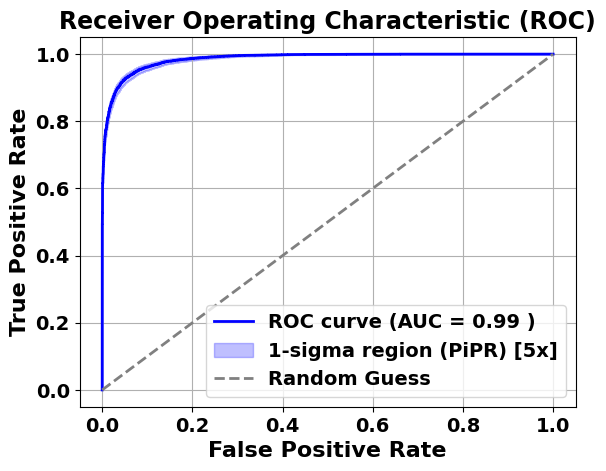

In [11]:
evaluate_model(model_test, test_loader, nn.CrossEntropyLoss(), device, return_accuracy=True)